In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    # for filename in filenames:
        # print(os.path.join(dirname, filename))
    print(dirname)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/YouTube-real
/kaggle/input/Celeb-synthesis
/kaggle/input/Celeb-real


In [2]:
celeb_real = "/kaggle/input/Celeb-real"
celeb_synthesis = "/kaggle/input/Celeb-synthesis"
youtube_real = "/kaggle/input/YouTube-real"

## EDA

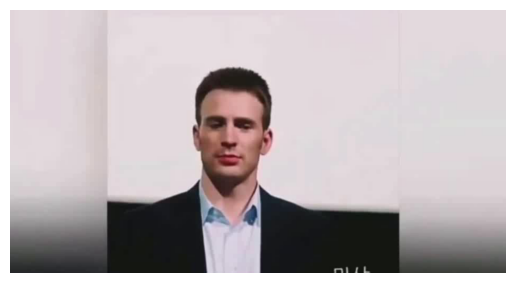

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def show_frame_from_video(video_path, frame_number=0):
    """
    Extracts a specific frame from a video.

    Parameters:
    - video_path (str): Path to the video file.
    - frame_number (int): The frame number to extract (default is 0, the first frame).

    Returns:
    - frame: The extracted frame as a NumPy array.
    """
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise ValueError("Could not open the video file.")
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    
    if not ret:
        raise ValueError("Could not read the frame.")
    
    cap.release()
    
    # Convert from BGR (OpenCV) to RGB (Matplotlib)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Display the image inline
    plt.imshow(frame_rgb)
    plt.axis('off')  # Hide axes
    plt.show()

    return frame

video_path = "/kaggle/input/Celeb-real/id4_0004.mp4"
frame = show_frame_from_video(video_path, frame_number=0)



In [4]:
# Spatial Domain Analysis
print("Frame Shape:", frame.shape)  # Height, Width, Channels
print("Frame Size:", frame.size)    # Total number of pixels
print("Frame Data Type:", frame.dtype)

Frame Shape: (500, 942, 3)
Frame Size: 1413000
Frame Data Type: uint8


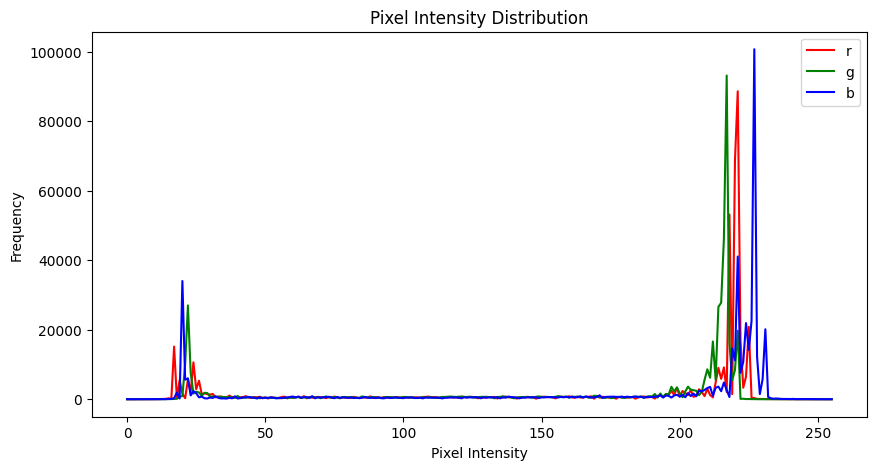

In [5]:
# Plot histograms for each channel (R, G, B)
colors = ('r', 'g', 'b')
plt.figure(figsize=(10, 5))
for i, color in enumerate(colors):
    hist = cv2.calcHist([frame], [i], None, [256], [0, 256])
    plt.plot(hist, color=color)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend(colors)
plt.show()

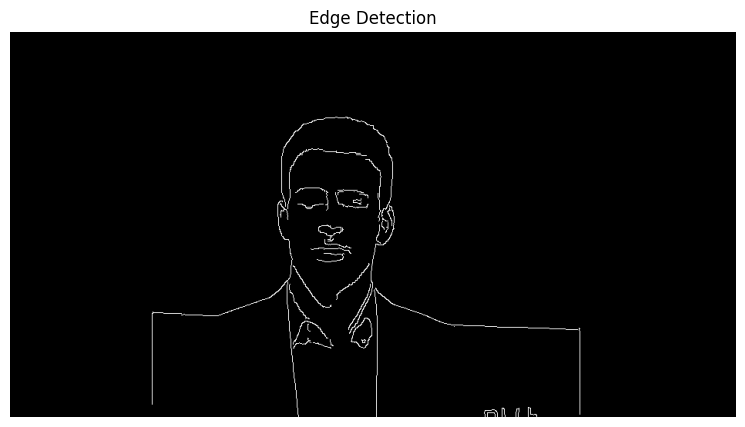

In [6]:
# Edge Detection (Spatial Features)
edges = cv2.Canny(frame, threshold1=100, threshold2=200)
plt.figure(figsize=(10, 5))
plt.imshow(edges, cmap='gray')
plt.title("Edge Detection")
plt.axis('off')
plt.show(
    
)

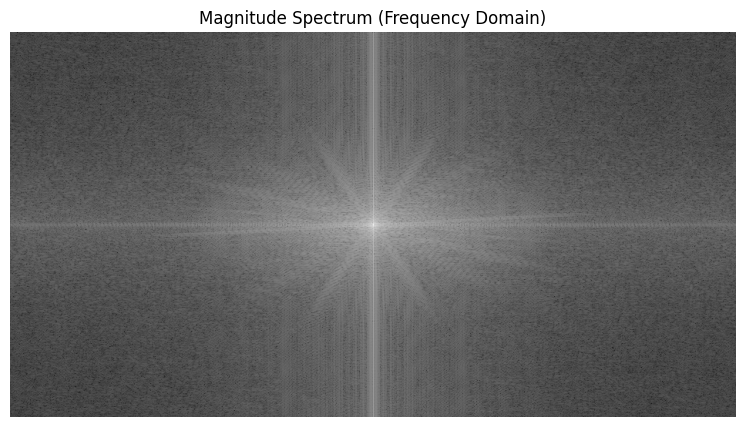

In [7]:
from scipy.fftpack import fft2, fftshift
import numpy as np

# Frequency Domain Analysis
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
f_transform = fft2(gray_frame)                        # Compute 2D Fourier Transform
f_transform_shifted = fftshift(f_transform)           # Shift zero frequency to center
magnitude_spectrum = 20 * np.log(np.abs(f_transform_shifted))  # Magnitude spectrum

# Plot the magnitude spectrum
plt.figure(figsize=(10, 5))
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title("Magnitude Spectrum (Frequency Domain)")
plt.axis('off')
plt.show()

## Preprocessing

Real videos: 408
Fake videos: 795


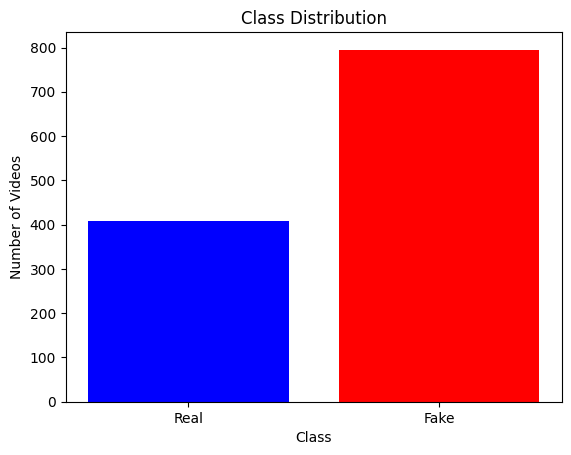

In [8]:
import os
import matplotlib.pyplot as plt

def count_videos(directories, label):
    """
    Count the number of videos in the given directories.
    
    Args:
        directories (list): List of directories to count videos from.
        label (str): Label for the class (e.g., 'real' or 'fake').
    
    Returns:
        int: Total number of videos.
    """
    count = 0
    for directory in directories:
        if os.path.exists(directory):
            count += len([f for f in os.listdir(directory) if f.endswith(('.mp4', '.avi', '.mov'))])
        else:
            print(f"Directory {directory} does not exist.")
    return count

def plot_class_distribution(real_count, fake_count):
    """
    Plot the class distribution as a bar chart.
    
    Args:
        real_count (int): Number of real videos.
        fake_count (int): Number of fake videos.
    """
    labels = ['Real', 'Fake']
    counts = [real_count, fake_count]
    
    plt.bar(labels, counts, color=['blue', 'red'])
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Videos')
    plt.show()

# Define directories
celeb_real = "/kaggle/input/Celeb-real"
celeb_synthesis = "/kaggle/input/Celeb-synthesis"
youtube_real = "/kaggle/input/YouTube-real"

# Count real and fake videos
real_directories = [celeb_real, youtube_real]
fake_directories = [celeb_synthesis]

real_count = count_videos(real_directories, 'real')
fake_count = count_videos(fake_directories, 'fake')

# Print the counts
print(f"Real videos: {real_count}")
print(f"Fake videos: {fake_count}")

# Plot the class distribution
plot_class_distribution(real_count, fake_count)

### --------------------------------------

In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

def extract_frames(video_path, output_dir, max_frames=30):
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    while cap.isOpened() and frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        cv2.imwrite(os.path.join(output_dir, f"frame_{frame_count:04d}.jpg"), frame)
        frame_count += 1
    cap.release()

def balanced_split(real_videos, fake_videos, split_ratio=(0.7, 0.15, 0.15)):
    # Ensure we use the minimum class count
    min_count = min(len(real_videos), len(fake_videos))
    real_videos = real_videos[:min_count]
    fake_videos = fake_videos[:min_count]
    
    # Create indices and shuffle
    indices = np.arange(min_count)
    np.random.shuffle(indices)
    
    # Calculate split points
    train_end = int(min_count * split_ratio[0])
    val_end = train_end + int(min_count * split_ratio[1])
    
    # Split indices
    splits = {
        'train': indices[:train_end],
        'val': indices[train_end:val_end],
        'test': indices[val_end:]
    }
    
    # Create balanced splits
    split_data = {}
    for split_name, idx in splits.items():
        split_data[split_name] = {
            'real': [real_videos[i] for i in idx],
            'fake': [fake_videos[i] for i in idx]
        }
    
    return split_data

def process_balanced_splits(split_data, output_base):
    for split_name in ['train', 'val', 'test']:
        # Process real videos
        real_output = os.path.join(output_base, split_name, 'real')
        for video in tqdm(split_data[split_name]['real'], desc=f'Processing {split_name} real'):
            vid_name = os.path.splitext(os.path.basename(video))[0]
            extract_frames(video, os.path.join(real_output, vid_name))
        
        # Process fake videos
        fake_output = os.path.join(output_base, split_name, 'fake')
        for video in tqdm(split_data[split_name]['fake'], desc=f'Processing {split_name} fake'):
            vid_name = os.path.splitext(os.path.basename(video))[0]
            extract_frames(video, os.path.join(fake_output, vid_name))

# Collect video paths
real_dirs = [celeb_real, youtube_real]
fake_dirs = [celeb_synthesis]

real_videos = [os.path.join(d, v) for d in real_dirs for v in os.listdir(d)]
fake_videos = [os.path.join(d, v) for d in fake_dirs for v in os.listdir(d)]

# Shuffle and split
split_data = balanced_split(real_videos, fake_videos)
process_balanced_splits(split_data, '/kaggle/working/data')

class BalancedDeepfakeDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.split_dir = os.path.join(root_dir, split)
        self.samples = []
        
        # Load real and fake with balanced classes
        real_path = os.path.join(self.split_dir, 'real')
        fake_path = os.path.join(self.split_dir, 'fake')
        
        # Collect real samples
        for vid_dir in os.listdir(real_path):
            frames = os.listdir(os.path.join(real_path, vid_dir))
            self.samples.extend([(os.path.join(real_path, vid_dir, f), 0) for f in frames])
        
        # Collect fake samples
        for vid_dir in os.listdir(fake_path):
            frames = os.listdir(os.path.join(fake_path, vid_dir))
            self.samples.extend([(os.path.join(fake_path, vid_dir, f), 1) for f in frames])
        
        # Shuffle to mix real and fake
        np.random.shuffle(self.samples)
        self.transform = transform

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        return img, label

# Transforms remain the same
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = BalancedDeepfakeDataset('/kaggle/working/data', 'train', train_transform)
val_dataset = BalancedDeepfakeDataset('/kaggle/working/data', 'val', val_transform)
test_dataset = BalancedDeepfakeDataset('/kaggle/working/data', 'test', val_transform)

# Create balanced data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

Processing test fake: 100%|██████████| 62/62 [00:04<00:00, 12.46it/s]


In [4]:
import os
from collections import defaultdict

def count_dataset_stats(root_dir):
    stats = defaultdict(lambda: defaultdict(lambda: {'videos': 0, 'frames': 0}))
    
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(root_dir, split)
        for class_name in ['real', 'fake']:
            class_path = os.path.join(split_path, class_name)
            if not os.path.exists(class_path):
                continue
                
            # Count videos
            videos = os.listdir(class_path)
            stats[split][class_name]['videos'] = len(videos)
            
            # Count frames
            total_frames = 0
            for video in videos:
                video_path = os.path.join(class_path, video)
                if os.path.isdir(video_path):
                    frames = os.listdir(video_path)
                    total_frames += len(frames)
            stats[split][class_name]['frames'] = total_frames
            
    return stats

def print_balance_report(stats):
    for split in ['train', 'val', 'test']:
        print(f"\n{split.upper()} Split:")
        if split not in stats:
            print("  No data found")
            continue
            
        real_videos = stats[split]['real']['videos']
        fake_videos = stats[split]['fake']['videos']
        real_frames = stats[split]['real']['frames']
        fake_frames = stats[split]['fake']['frames']
        
        print(f"  Videos - Real: {real_videos}, Fake: {fake_videos}")
        print(f"  Frames - Real: {real_frames}, Fake: {fake_frames}")
        
        video_ratio = real_videos / fake_videos if fake_videos != 0 else 0
        frame_ratio = real_frames / fake_frames if fake_frames != 0 else 0
        
        print(f"  Video Class Ratio (Real/Fake): {video_ratio:.2f}:1")
        print(f"  Frame Class Ratio (Real/Fake): {frame_ratio:.2f}:1")

# Check directory structure balance
directory_stats = count_dataset_stats('/kaggle/working/data')
print_balance_report(directory_stats)

# Check Dataset class balance
def check_dataset_balance(dataset, name):
    class_counts = [0, 0]
    for _, label in dataset:
        class_counts[label] += 1
        
    print(f"\n{name} Dataset:")
    print(f"  Total samples: {len(dataset)}")
    print(f"  Real samples: {class_counts[0]} ({class_counts[0]/len(dataset):.1%})")
    print(f"  Fake samples: {class_counts[1]} ({class_counts[1]/len(dataset):.1%})")
    print(f"  Class ratio: {class_counts[0]/class_counts[1]:.2f}:1")

check_dataset_balance(train_dataset, "Training")
check_dataset_balance(val_dataset, "Validation")
check_dataset_balance(test_dataset, "Test")



TRAIN Split:
  Videos - Real: 285, Fake: 285
  Frames - Real: 8550, Fake: 8550
  Video Class Ratio (Real/Fake): 1.00:1
  Frame Class Ratio (Real/Fake): 1.00:1

VAL Split:
  Videos - Real: 61, Fake: 61
  Frames - Real: 1830, Fake: 1830
  Video Class Ratio (Real/Fake): 1.00:1
  Frame Class Ratio (Real/Fake): 1.00:1

TEST Split:
  Videos - Real: 62, Fake: 62
  Frames - Real: 1860, Fake: 1860
  Video Class Ratio (Real/Fake): 1.00:1
  Frame Class Ratio (Real/Fake): 1.00:1


KeyboardInterrupt: 

## Model

In [5]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import efficientnet_v2_s

class FrequencyDomainTransform(nn.Module):
    def forward(self, x):
        fft = torch.fft.fft2(x, dim=(-2, -1))
        magnitude = torch.log(torch.abs(fft) + 1e-4)
        return magnitude

class DualStreamFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        # Spatial stream
        self.spatial_stream = efficientnet_v2_s(pretrained=True).features
        # Frequency stream
        self.freq_conv = nn.Conv2d(3, 3, kernel_size=3, padding=1)  # Learnable frequency adapter
        self.freq_stream = efficientnet_v2_s(pretrained=True).features
        
    def forward(self, x):
        # Frequency stream
        freq_x = self.freq_conv(x)
        freq_features = self.freq_stream(freq_x)
        
        # Spatial stream
        spatial_features = self.spatial_stream(x)
        
        return spatial_features, freq_features

class CrossAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.query = nn.Conv2d(channels, channels//8, 1)
        self.key = nn.Conv2d(channels, channels//8, 1)
        self.value = nn.Conv2d(channels, channels, 1)
        
    def forward(self, spatial, freq):
        bs = spatial.size(0)
        Q = self.query(spatial).view(bs, -1, spatial.size(2)*spatial.size(3))
        K = self.key(freq).view(bs, -1, freq.size(2)*freq.size(3))
        V = self.value(freq).view(bs, -1, freq.size(2)*freq.size(3))
        
        attn = torch.softmax(torch.bmm(Q.transpose(1,2), K), dim=-1)
        out = torch.bmm(V, attn).view_as(spatial)
        return spatial + out

class DeepfakeDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.freq_transform = FrequencyDomainTransform()
        self.features = DualStreamFeatureExtractor()
        self.attention = CrossAttention(1280)  # EfficientNetV2-S feature size
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(1280, 1),
            nn.Sigmoid()
        )
        self.localization = nn.Sequential(
            nn.Conv2d(1280, 256, 3, padding=1),
            nn.Upsample(scale_factor=4, mode='bilinear'),
            nn.Conv2d(256, 1, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x_freq = self.freq_transform(x)
        spatial, freq = self.features(x)
        attn_features = self.attention(spatial, freq)
        auth = self.classifier(attn_features)
        loc = self.localization(attn_features)
        return auth, loc

### --------------------------------------

# Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score, 
                             recall_score, f1_score, confusion_matrix, roc_curve)

# Assume that train_loader and val_loader are defined elsewhere and that your 
# DeepfakeDetector (with the corrected typo in classifier call) is imported/defined.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepfakeDetector().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.BCELoss()

num_epochs = 100
best_val_auc = 0.0

# For storing metrics over epochs
train_loss_history, val_loss_history = [], []
metrics_history = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    train_preds, train_labels = [], []
    
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
    for inputs, labels in train_loop:
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        
        optimizer.zero_grad()
        auth, _ = model(inputs)
        loss = criterion(auth.squeeze(), labels)
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        epoch_train_loss += loss.item() * inputs.size(0)
        # Save predictions and ground truth for metric calculation
        train_preds.extend(auth.detach().cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
        
        train_loop.set_postfix(loss=loss.item())
    
    epoch_train_loss /= len(train_loader.dataset)
    train_loss_history.append(epoch_train_loss)
    
    # Compute training metrics
    train_auc      = roc_auc_score(train_labels, train_preds)
    train_acc      = accuracy_score(train_labels, (np.array(train_preds) >= 0.5).astype(int))
    train_precision= precision_score(train_labels, (np.array(train_preds) >= 0.5).astype(int))
    train_recall   = recall_score(train_labels, (np.array(train_preds) >= 0.5).astype(int))
    train_f1       = f1_score(train_labels, (np.array(train_preds) >= 0.5).astype(int))
    
    # ---- Validation ----
    model.eval()
    epoch_val_loss = 0.0
    val_preds, val_labels = [], []
    
    val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")
    with torch.no_grad():
        for inputs, labels in val_loop:
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            
            auth, _ = model(inputs)
            loss = criterion(auth.squeeze(), labels)
            epoch_val_loss += loss.item() * inputs.size(0)
            
            val_preds.extend(auth.detach().cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    epoch_val_loss /= len(val_loader.dataset)
    val_loss_history.append(epoch_val_loss)
    
    val_auc       = roc_auc_score(val_labels, val_preds)
    val_acc       = accuracy_score(val_labels, (np.array(val_preds) >= 0.5).astype(int))
    val_precision = precision_score(val_labels, (np.array(val_preds) >= 0.5).astype(int))
    val_recall    = recall_score(val_labels, (np.array(val_preds) >= 0.5).astype(int))
    val_f1        = f1_score(val_labels, (np.array(val_preds) >= 0.5).astype(int))
    
    # Save the best model based on validation AUC
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), 'best_model.pth')
    
    # Log epoch metrics
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Train Loss: {epoch_train_loss:.4f} | AUC: {train_auc:.4f} | Acc: {train_acc:.4f} | "
          f"Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1: {train_f1:.4f}")
    print(f"Val   Loss: {epoch_val_loss:.4f} | AUC: {val_auc:.4f} | Acc: {val_acc:.4f} | "
          f"Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f}")
    
    metrics_history.append({
        'epoch': epoch + 1,
        'train_loss': epoch_train_loss,
        'val_loss': epoch_val_loss,
        'train_auc': train_auc,
        'val_auc': val_auc,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'train_precision': train_precision,
        'val_precision': val_precision,
        'train_recall': train_recall,
        'val_recall': val_recall,
        'train_f1': train_f1,
        'val_f1': val_f1,
    })

# ---- Overfitting Check ----
print("\nTraining Complete!")
avg_train_loss = np.mean(train_loss_history)
avg_val_loss = np.mean(val_loss_history)
if avg_train_loss < avg_val_loss:
    print("Observation: Training loss is consistently lower than validation loss. This may indicate overfitting. "
          "Consider data augmentation, dropout, or additional regularization.")
else:
    print("Observation: Training and validation losses are similar, suggesting a good fit.")

# ---- Plotting Diagrams for the Research Paper ----

# 1. Loss Curves
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_loss_history, marker='o', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve.png')
plt.show()

# 2. ROC Curve (using the last epoch's validation predictions)
fpr, tpr, _ = roc_curve(val_labels, val_preds)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {val_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('roc_curve.png')
plt.show()

# 3. Confusion Matrix
# Threshold predictions at 0.5
binary_preds = (np.array(val_preds) >= 0.5).astype(int)
cm = confusion_matrix(val_labels, binary_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 188MB/s]
Epoch 1/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.83it/s]



Epoch 1 Summary:
Train Loss: 0.1220 | AUC: 0.9908 | Acc: 0.9523 | Precision: 0.9494 | Recall: 0.9554 | F1: 0.9524
Val   Loss: 0.3464 | AUC: 0.9482 | Acc: 0.8680 | Precision: 0.8521 | Recall: 0.8907 | F1: 0.8710


Epoch 2/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.87it/s]



Epoch 2 Summary:
Train Loss: 0.0299 | AUC: 0.9993 | Acc: 0.9906 | Precision: 0.9904 | Recall: 0.9909 | F1: 0.9906
Val   Loss: 0.5885 | AUC: 0.9515 | Acc: 0.8413 | Precision: 0.7740 | Recall: 0.9639 | F1: 0.8586


Epoch 3/100 [Validation]: 100%|██████████| 229/229 [00:38<00:00,  5.87it/s]



Epoch 3 Summary:
Train Loss: 0.0230 | AUC: 0.9995 | Acc: 0.9933 | Precision: 0.9933 | Recall: 0.9933 | F1: 0.9933
Val   Loss: 0.4821 | AUC: 0.9781 | Acc: 0.8579 | Precision: 0.7878 | Recall: 0.9798 | F1: 0.8734


Epoch 4/100 [Validation]: 100%|██████████| 229/229 [00:38<00:00,  5.87it/s]



Epoch 4 Summary:
Train Loss: 0.0131 | AUC: 0.9998 | Acc: 0.9960 | Precision: 0.9966 | Recall: 0.9954 | F1: 0.9960
Val   Loss: 0.9789 | AUC: 0.9411 | Acc: 0.8814 | Precision: 0.8913 | Recall: 0.8689 | F1: 0.8799


Epoch 5/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.85it/s]



Epoch 5 Summary:
Train Loss: 0.0131 | AUC: 0.9997 | Acc: 0.9961 | Precision: 0.9961 | Recall: 0.9960 | F1: 0.9961
Val   Loss: 0.4190 | AUC: 0.9676 | Acc: 0.9057 | Precision: 0.8674 | Recall: 0.9579 | F1: 0.9104


Epoch 6/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.87it/s]



Epoch 6 Summary:
Train Loss: 0.0181 | AUC: 0.9995 | Acc: 0.9946 | Precision: 0.9945 | Recall: 0.9946 | F1: 0.9946
Val   Loss: 0.3037 | AUC: 0.9756 | Acc: 0.9347 | Precision: 0.9238 | Recall: 0.9475 | F1: 0.9355


Epoch 7/100 [Validation]: 100%|██████████| 229/229 [00:38<00:00,  5.88it/s]



Epoch 7 Summary:
Train Loss: 0.0060 | AUC: 1.0000 | Acc: 0.9981 | Precision: 0.9978 | Recall: 0.9985 | F1: 0.9981
Val   Loss: 0.3320 | AUC: 0.9721 | Acc: 0.9019 | Precision: 0.9093 | Recall: 0.8929 | F1: 0.9010


Epoch 8/100 [Validation]: 100%|██████████| 229/229 [00:38<00:00,  5.88it/s]



Epoch 8 Summary:
Train Loss: 0.0116 | AUC: 0.9998 | Acc: 0.9965 | Precision: 0.9966 | Recall: 0.9964 | F1: 0.9965
Val   Loss: 0.3395 | AUC: 0.9731 | Acc: 0.9046 | Precision: 0.8962 | Recall: 0.9153 | F1: 0.9057


Epoch 9/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.87it/s]



Epoch 9 Summary:
Train Loss: 0.0086 | AUC: 0.9998 | Acc: 0.9976 | Precision: 0.9981 | Recall: 0.9971 | F1: 0.9976
Val   Loss: 0.3472 | AUC: 0.9772 | Acc: 0.9224 | Precision: 0.9116 | Recall: 0.9355 | F1: 0.9234


Epoch 10/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.86it/s]



Epoch 10 Summary:
Train Loss: 0.0070 | AUC: 0.9999 | Acc: 0.9982 | Precision: 0.9982 | Recall: 0.9981 | F1: 0.9982
Val   Loss: 0.2531 | AUC: 0.9815 | Acc: 0.9219 | Precision: 0.9085 | Recall: 0.9383 | F1: 0.9231


Epoch 11/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.87it/s]



Epoch 11 Summary:
Train Loss: 0.0074 | AUC: 0.9999 | Acc: 0.9980 | Precision: 0.9982 | Recall: 0.9977 | F1: 0.9980
Val   Loss: 0.3472 | AUC: 0.9792 | Acc: 0.9219 | Precision: 0.9209 | Recall: 0.9230 | F1: 0.9219


Epoch 12/100 [Validation]: 100%|██████████| 229/229 [00:38<00:00,  5.89it/s]



Epoch 12 Summary:
Train Loss: 0.0101 | AUC: 0.9996 | Acc: 0.9978 | Precision: 0.9978 | Recall: 0.9979 | F1: 0.9978
Val   Loss: 1.0982 | AUC: 0.9555 | Acc: 0.9008 | Precision: 0.8783 | Recall: 0.9306 | F1: 0.9037


Epoch 13/100 [Validation]: 100%|██████████| 229/229 [00:38<00:00,  5.88it/s]



Epoch 13 Summary:
Train Loss: 0.0055 | AUC: 1.0000 | Acc: 0.9985 | Precision: 0.9989 | Recall: 0.9980 | F1: 0.9985
Val   Loss: 0.5578 | AUC: 0.9653 | Acc: 0.8945 | Precision: 0.8820 | Recall: 0.9109 | F1: 0.8962


Epoch 14/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.83it/s]



Epoch 14 Summary:
Train Loss: 0.0045 | AUC: 0.9999 | Acc: 0.9988 | Precision: 0.9991 | Recall: 0.9985 | F1: 0.9988
Val   Loss: 0.4172 | AUC: 0.9767 | Acc: 0.9107 | Precision: 0.8678 | Recall: 0.9689 | F1: 0.9156


Epoch 15/100 [Validation]: 100%|██████████| 229/229 [00:38<00:00,  5.88it/s]



Epoch 15 Summary:
Train Loss: 0.0029 | AUC: 0.9999 | Acc: 0.9994 | Precision: 0.9996 | Recall: 0.9992 | F1: 0.9994
Val   Loss: 0.3631 | AUC: 0.9835 | Acc: 0.9161 | Precision: 0.8879 | Recall: 0.9525 | F1: 0.9191


Epoch 16/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.86it/s]



Epoch 16 Summary:
Train Loss: 0.0074 | AUC: 0.9999 | Acc: 0.9977 | Precision: 0.9978 | Recall: 0.9975 | F1: 0.9977
Val   Loss: 0.3868 | AUC: 0.9808 | Acc: 0.9276 | Precision: 0.8926 | Recall: 0.9721 | F1: 0.9307


Epoch 17/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.87it/s]



Epoch 17 Summary:
Train Loss: 0.0069 | AUC: 1.0000 | Acc: 0.9978 | Precision: 0.9979 | Recall: 0.9977 | F1: 0.9978
Val   Loss: 0.1943 | AUC: 0.9857 | Acc: 0.9399 | Precision: 0.9328 | Recall: 0.9481 | F1: 0.9404


Epoch 18/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.86it/s]



Epoch 18 Summary:
Train Loss: 0.0049 | AUC: 0.9999 | Acc: 0.9988 | Precision: 0.9986 | Recall: 0.9991 | F1: 0.9988
Val   Loss: 0.2115 | AUC: 0.9829 | Acc: 0.9270 | Precision: 0.9349 | Recall: 0.9180 | F1: 0.9264


Epoch 19/100 [Validation]: 100%|██████████| 229/229 [00:38<00:00,  5.87it/s]



Epoch 19 Summary:
Train Loss: 0.0041 | AUC: 1.0000 | Acc: 0.9989 | Precision: 0.9992 | Recall: 0.9987 | F1: 0.9989
Val   Loss: 0.3142 | AUC: 0.9759 | Acc: 0.9164 | Precision: 0.9137 | Recall: 0.9197 | F1: 0.9167


Epoch 20/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.87it/s]



Epoch 20 Summary:
Train Loss: 0.0056 | AUC: 1.0000 | Acc: 0.9985 | Precision: 0.9986 | Recall: 0.9985 | F1: 0.9985
Val   Loss: 0.3496 | AUC: 0.9764 | Acc: 0.9221 | Precision: 0.8947 | Recall: 0.9568 | F1: 0.9247


Epoch 21/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.85it/s]



Epoch 21 Summary:
Train Loss: 0.0066 | AUC: 1.0000 | Acc: 0.9978 | Precision: 0.9980 | Recall: 0.9975 | F1: 0.9978
Val   Loss: 0.3344 | AUC: 0.9750 | Acc: 0.9145 | Precision: 0.9028 | Recall: 0.9290 | F1: 0.9157


Epoch 22/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.86it/s]



Epoch 22 Summary:
Train Loss: 0.0011 | AUC: 1.0000 | Acc: 0.9996 | Precision: 0.9998 | Recall: 0.9995 | F1: 0.9996
Val   Loss: 0.3651 | AUC: 0.9820 | Acc: 0.9101 | Precision: 0.8815 | Recall: 0.9475 | F1: 0.9134


Epoch 23/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.86it/s]



Epoch 23 Summary:
Train Loss: 0.0000 | AUC: 1.0000 | Acc: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000
Val   Loss: 0.3395 | AUC: 0.9834 | Acc: 0.9260 | Precision: 0.9171 | Recall: 0.9366 | F1: 0.9267


Epoch 24/100 [Validation]: 100%|██████████| 229/229 [00:38<00:00,  5.88it/s]



Epoch 24 Summary:
Train Loss: 0.0075 | AUC: 0.9999 | Acc: 0.9976 | Precision: 0.9980 | Recall: 0.9972 | F1: 0.9976
Val   Loss: 0.3683 | AUC: 0.9796 | Acc: 0.9246 | Precision: 0.9425 | Recall: 0.9044 | F1: 0.9230


Epoch 25/100 [Validation]: 100%|██████████| 229/229 [00:38<00:00,  5.87it/s]



Epoch 25 Summary:
Train Loss: 0.0044 | AUC: 1.0000 | Acc: 0.9983 | Precision: 0.9982 | Recall: 0.9984 | F1: 0.9983
Val   Loss: 0.4382 | AUC: 0.9739 | Acc: 0.9071 | Precision: 0.9782 | Recall: 0.8328 | F1: 0.8996


Epoch 26/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.86it/s]



Epoch 26 Summary:
Train Loss: 0.0031 | AUC: 1.0000 | Acc: 0.9993 | Precision: 0.9992 | Recall: 0.9994 | F1: 0.9993
Val   Loss: 0.3163 | AUC: 0.9851 | Acc: 0.9434 | Precision: 0.9656 | Recall: 0.9197 | F1: 0.9421


Epoch 27/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.86it/s]



Epoch 27 Summary:
Train Loss: 0.0059 | AUC: 0.9999 | Acc: 0.9987 | Precision: 0.9989 | Recall: 0.9984 | F1: 0.9987
Val   Loss: 0.3350 | AUC: 0.9781 | Acc: 0.9216 | Precision: 0.9054 | Recall: 0.9415 | F1: 0.9231


Epoch 28/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.86it/s]



Epoch 28 Summary:
Train Loss: 0.0026 | AUC: 1.0000 | Acc: 0.9994 | Precision: 0.9993 | Recall: 0.9994 | F1: 0.9994
Val   Loss: 0.3262 | AUC: 0.9790 | Acc: 0.9361 | Precision: 0.9645 | Recall: 0.9055 | F1: 0.9340


Epoch 29/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.83it/s]



Epoch 29 Summary:
Train Loss: 0.0029 | AUC: 1.0000 | Acc: 0.9994 | Precision: 0.9994 | Recall: 0.9993 | F1: 0.9994
Val   Loss: 0.3742 | AUC: 0.9875 | Acc: 0.9128 | Precision: 0.8709 | Recall: 0.9694 | F1: 0.9175


Epoch 30/100 [Validation]: 100%|██████████| 229/229 [00:38<00:00,  5.87it/s]



Epoch 30 Summary:
Train Loss: 0.0036 | AUC: 0.9999 | Acc: 0.9991 | Precision: 0.9991 | Recall: 0.9992 | F1: 0.9991
Val   Loss: 0.2414 | AUC: 0.9824 | Acc: 0.9189 | Precision: 0.9041 | Recall: 0.9372 | F1: 0.9203


Epoch 31/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.86it/s]



Epoch 31 Summary:
Train Loss: 0.0052 | AUC: 1.0000 | Acc: 0.9984 | Precision: 0.9986 | Recall: 0.9982 | F1: 0.9984
Val   Loss: 0.2627 | AUC: 0.9769 | Acc: 0.9148 | Precision: 0.9059 | Recall: 0.9257 | F1: 0.9157


Epoch 32/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.86it/s]



Epoch 32 Summary:
Train Loss: 0.0017 | AUC: 1.0000 | Acc: 0.9995 | Precision: 0.9993 | Recall: 0.9996 | F1: 0.9995
Val   Loss: 0.4485 | AUC: 0.9718 | Acc: 0.9202 | Precision: 0.9188 | Recall: 0.9219 | F1: 0.9203


Epoch 33/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.85it/s]



Epoch 33 Summary:
Train Loss: 0.0033 | AUC: 1.0000 | Acc: 0.9991 | Precision: 0.9991 | Recall: 0.9992 | F1: 0.9991
Val   Loss: 0.2525 | AUC: 0.9843 | Acc: 0.9404 | Precision: 0.9758 | Recall: 0.9033 | F1: 0.9381


Epoch 34/100 [Validation]: 100%|██████████| 229/229 [00:38<00:00,  5.87it/s]



Epoch 34 Summary:
Train Loss: 0.0035 | AUC: 1.0000 | Acc: 0.9991 | Precision: 0.9991 | Recall: 0.9991 | F1: 0.9991
Val   Loss: 0.1847 | AUC: 0.9902 | Acc: 0.9426 | Precision: 0.9535 | Recall: 0.9306 | F1: 0.9419


Epoch 35/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.86it/s]



Epoch 35 Summary:
Train Loss: 0.0027 | AUC: 1.0000 | Acc: 0.9994 | Precision: 0.9994 | Recall: 0.9994 | F1: 0.9994
Val   Loss: 0.3298 | AUC: 0.9889 | Acc: 0.9066 | Precision: 0.8509 | Recall: 0.9858 | F1: 0.9134


Epoch 36/100 [Validation]: 100%|██████████| 229/229 [00:38<00:00,  5.90it/s]



Epoch 36 Summary:
Train Loss: 0.0048 | AUC: 0.9999 | Acc: 0.9986 | Precision: 0.9981 | Recall: 0.9991 | F1: 0.9986
Val   Loss: 0.2098 | AUC: 0.9858 | Acc: 0.9333 | Precision: 0.9348 | Recall: 0.9317 | F1: 0.9332


Epoch 37/100 [Validation]: 100%|██████████| 229/229 [00:38<00:00,  5.91it/s]



Epoch 37 Summary:
Train Loss: 0.0024 | AUC: 1.0000 | Acc: 0.9993 | Precision: 0.9993 | Recall: 0.9993 | F1: 0.9993
Val   Loss: 0.1292 | AUC: 0.9938 | Acc: 0.9587 | Precision: 0.9677 | Recall: 0.9492 | F1: 0.9583


Epoch 38/100 [Validation]: 100%|██████████| 229/229 [00:38<00:00,  5.88it/s]



Epoch 38 Summary:
Train Loss: 0.0047 | AUC: 0.9999 | Acc: 0.9987 | Precision: 0.9988 | Recall: 0.9985 | F1: 0.9987
Val   Loss: 0.2229 | AUC: 0.9899 | Acc: 0.9295 | Precision: 0.8974 | Recall: 0.9699 | F1: 0.9322


Epoch 39/100 [Validation]: 100%|██████████| 229/229 [00:38<00:00,  5.89it/s]



Epoch 39 Summary:
Train Loss: 0.0007 | AUC: 1.0000 | Acc: 0.9999 | Precision: 0.9999 | Recall: 1.0000 | F1: 0.9999
Val   Loss: 0.2227 | AUC: 0.9905 | Acc: 0.9456 | Precision: 0.9313 | Recall: 0.9623 | F1: 0.9465


Epoch 40/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.85it/s]



Epoch 40 Summary:
Train Loss: 0.0035 | AUC: 1.0000 | Acc: 0.9990 | Precision: 0.9988 | Recall: 0.9992 | F1: 0.9990
Val   Loss: 0.5344 | AUC: 0.9722 | Acc: 0.9090 | Precision: 0.9826 | Recall: 0.8328 | F1: 0.9015


Epoch 41/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.86it/s]



Epoch 41 Summary:
Train Loss: 0.0048 | AUC: 0.9999 | Acc: 0.9986 | Precision: 0.9985 | Recall: 0.9987 | F1: 0.9986
Val   Loss: 0.2494 | AUC: 0.9829 | Acc: 0.9301 | Precision: 0.9195 | Recall: 0.9426 | F1: 0.9309


Epoch 42/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.86it/s]



Epoch 42 Summary:
Train Loss: 0.0019 | AUC: 1.0000 | Acc: 0.9996 | Precision: 0.9998 | Recall: 0.9995 | F1: 0.9996
Val   Loss: 0.2269 | AUC: 0.9883 | Acc: 0.9432 | Precision: 0.9351 | Recall: 0.9525 | F1: 0.9437


Epoch 43/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.87it/s]



Epoch 43 Summary:
Train Loss: 0.0009 | AUC: 1.0000 | Acc: 0.9996 | Precision: 0.9996 | Recall: 0.9996 | F1: 0.9996
Val   Loss: 0.3545 | AUC: 0.9838 | Acc: 0.9290 | Precision: 0.9371 | Recall: 0.9197 | F1: 0.9283


Epoch 44/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.86it/s]



Epoch 44 Summary:
Train Loss: 0.0052 | AUC: 1.0000 | Acc: 0.9985 | Precision: 0.9992 | Recall: 0.9979 | F1: 0.9985
Val   Loss: 0.1351 | AUC: 0.9918 | Acc: 0.9604 | Precision: 0.9581 | Recall: 0.9628 | F1: 0.9605


Epoch 45/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.86it/s]



Epoch 45 Summary:
Train Loss: 0.0003 | AUC: 1.0000 | Acc: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000
Val   Loss: 0.1623 | AUC: 0.9946 | Acc: 0.9590 | Precision: 0.9393 | Recall: 0.9814 | F1: 0.9599


Epoch 46/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.85it/s]



Epoch 46 Summary:
Train Loss: 0.0032 | AUC: 1.0000 | Acc: 0.9988 | Precision: 0.9986 | Recall: 0.9991 | F1: 0.9988
Val   Loss: 0.2207 | AUC: 0.9866 | Acc: 0.9388 | Precision: 0.9308 | Recall: 0.9481 | F1: 0.9394


Epoch 47/100 [Validation]: 100%|██████████| 229/229 [00:38<00:00,  5.88it/s]



Epoch 47 Summary:
Train Loss: 0.0002 | AUC: 1.0000 | Acc: 0.9999 | Precision: 0.9999 | Recall: 1.0000 | F1: 0.9999
Val   Loss: 0.2078 | AUC: 0.9910 | Acc: 0.9519 | Precision: 0.9678 | Recall: 0.9350 | F1: 0.9511


Epoch 48/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.86it/s]



Epoch 48 Summary:
Train Loss: 0.0031 | AUC: 1.0000 | Acc: 0.9992 | Precision: 0.9991 | Recall: 0.9993 | F1: 0.9992
Val   Loss: 0.1917 | AUC: 0.9903 | Acc: 0.9459 | Precision: 0.9331 | Recall: 0.9607 | F1: 0.9467


Epoch 49/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.87it/s]



Epoch 49 Summary:
Train Loss: 0.0030 | AUC: 1.0000 | Acc: 0.9991 | Precision: 0.9989 | Recall: 0.9992 | F1: 0.9991
Val   Loss: 0.2028 | AUC: 0.9922 | Acc: 0.9393 | Precision: 0.9048 | Recall: 0.9820 | F1: 0.9418


Epoch 50/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.84it/s]



Epoch 50 Summary:
Train Loss: 0.0024 | AUC: 1.0000 | Acc: 0.9993 | Precision: 0.9992 | Recall: 0.9994 | F1: 0.9993
Val   Loss: 0.1994 | AUC: 0.9870 | Acc: 0.9369 | Precision: 0.9324 | Recall: 0.9421 | F1: 0.9372


Epoch 51/100 [Validation]: 100%|██████████| 229/229 [00:38<00:00,  5.89it/s]



Epoch 51 Summary:
Train Loss: 0.0012 | AUC: 1.0000 | Acc: 0.9998 | Precision: 0.9998 | Recall: 0.9999 | F1: 0.9998
Val   Loss: 0.2212 | AUC: 0.9897 | Acc: 0.9423 | Precision: 0.9530 | Recall: 0.9306 | F1: 0.9417


Epoch 52/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.87it/s]



Epoch 52 Summary:
Train Loss: 0.0032 | AUC: 0.9999 | Acc: 0.9994 | Precision: 0.9993 | Recall: 0.9995 | F1: 0.9994
Val   Loss: 0.1940 | AUC: 0.9900 | Acc: 0.9505 | Precision: 0.9635 | Recall: 0.9366 | F1: 0.9498


Epoch 53/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.87it/s]



Epoch 53 Summary:
Train Loss: 0.0036 | AUC: 1.0000 | Acc: 0.9988 | Precision: 0.9989 | Recall: 0.9987 | F1: 0.9988
Val   Loss: 0.2779 | AUC: 0.9850 | Acc: 0.9260 | Precision: 0.9347 | Recall: 0.9158 | F1: 0.9252


Epoch 54/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.85it/s]



Epoch 54 Summary:
Train Loss: 0.0002 | AUC: 1.0000 | Acc: 0.9999 | Precision: 1.0000 | Recall: 0.9999 | F1: 0.9999
Val   Loss: 0.3213 | AUC: 0.9862 | Acc: 0.9301 | Precision: 0.9086 | Recall: 0.9563 | F1: 0.9318


Epoch 55/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.87it/s]



Epoch 55 Summary:
Train Loss: 0.0014 | AUC: 1.0000 | Acc: 0.9995 | Precision: 0.9994 | Recall: 0.9996 | F1: 0.9995
Val   Loss: 0.3394 | AUC: 0.9857 | Acc: 0.9216 | Precision: 0.8806 | Recall: 0.9754 | F1: 0.9256


Epoch 56/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.84it/s]



Epoch 56 Summary:
Train Loss: 0.0012 | AUC: 1.0000 | Acc: 0.9998 | Precision: 0.9996 | Recall: 0.9999 | F1: 0.9998
Val   Loss: 0.1793 | AUC: 0.9917 | Acc: 0.9620 | Precision: 0.9726 | Recall: 0.9508 | F1: 0.9616


Epoch 57/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.85it/s]



Epoch 57 Summary:
Train Loss: 0.0039 | AUC: 1.0000 | Acc: 0.9987 | Precision: 0.9985 | Recall: 0.9988 | F1: 0.9987
Val   Loss: 0.1730 | AUC: 0.9902 | Acc: 0.9486 | Precision: 0.9887 | Recall: 0.9077 | F1: 0.9464


Epoch 58/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.85it/s]



Epoch 58 Summary:
Train Loss: 0.0004 | AUC: 1.0000 | Acc: 0.9999 | Precision: 1.0000 | Recall: 0.9998 | F1: 0.9999
Val   Loss: 0.2861 | AUC: 0.9869 | Acc: 0.9402 | Precision: 0.9099 | Recall: 0.9770 | F1: 0.9423


Epoch 59/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.86it/s]



Epoch 59 Summary:
Train Loss: 0.0029 | AUC: 1.0000 | Acc: 0.9992 | Precision: 0.9992 | Recall: 0.9993 | F1: 0.9992
Val   Loss: 0.3858 | AUC: 0.9698 | Acc: 0.9142 | Precision: 0.9075 | Recall: 0.9224 | F1: 0.9149


Epoch 60/100 [Validation]: 100%|██████████| 229/229 [00:38<00:00,  5.87it/s]



Epoch 60 Summary:
Train Loss: 0.0018 | AUC: 1.0000 | Acc: 0.9995 | Precision: 0.9995 | Recall: 0.9995 | F1: 0.9995
Val   Loss: 0.2010 | AUC: 0.9889 | Acc: 0.9492 | Precision: 0.9546 | Recall: 0.9432 | F1: 0.9489


Epoch 61/100 [Validation]: 100%|██████████| 229/229 [00:39<00:00,  5.85it/s]



Epoch 61 Summary:
Train Loss: 0.0031 | AUC: 1.0000 | Acc: 0.9991 | Precision: 0.9992 | Recall: 0.9989 | F1: 0.9991
Val   Loss: 0.2262 | AUC: 0.9864 | Acc: 0.9358 | Precision: 0.9318 | Recall: 0.9404 | F1: 0.9361


Epoch 62/100 [Validation]: 100%|██████████| 229/229 [00:38<00:00,  5.87it/s]



Epoch 62 Summary:
Train Loss: 0.0009 | AUC: 1.0000 | Acc: 0.9996 | Precision: 0.9996 | Recall: 0.9996 | F1: 0.9996
Val   Loss: 0.1901 | AUC: 0.9909 | Acc: 0.9560 | Precision: 0.9680 | Recall: 0.9432 | F1: 0.9554


Epoch 63/100 [Training]:  81%|████████▏ | 869/1069 [08:45<02:00,  1.65it/s, loss=4.54e-5] 

### --------------------------------------

# Sample using model:

## Loading model for use.

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import efficientnet_v2_s
import cv2
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt

# Define the model architecture (same as during training)
class FrequencyDomainTransform(nn.Module):
    def forward(self, x):
        fft = torch.fft.fft2(x, dim=(-2, -1))
        magnitude = torch.log(torch.abs(fft) + 1e-6)
        return magnitude

class DualStreamFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.spatial_stream = efficientnet_v2_s(pretrained=True).features
        self.freq_conv = nn.Conv2d(3, 3, kernel_size=3, padding=1)
        self.freq_stream = efficientnet_v2_s(pretrained=True).features
        
    def forward(self, x):
        freq_x = self.freq_conv(x)
        freq_features = self.freq_stream(freq_x)
        spatial_features = self.spatial_stream(x)
        return spatial_features, freq_features

class CrossAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.query = nn.Conv2d(channels, channels//8, 1)
        self.key = nn.Conv2d(channels, channels//8, 1)
        self.value = nn.Conv2d(channels, channels, 1)
        
    def forward(self, spatial, freq):
        bs = spatial.size(0)
        Q = self.query(spatial).view(bs, -1, spatial.size(2)*spatial.size(3))
        K = self.key(freq).view(bs, -1, freq.size(2)*freq.size(3))
        V = self.value(freq).view(bs, -1, freq.size(2)*freq.size(3))
        
        attn = torch.softmax(torch.bmm(Q.transpose(1,2), K), dim=-1)
        out = torch.bmm(V, attn).view_as(spatial)
        return spatial + out

class DeepfakeDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.freq_transform = FrequencyDomainTransform()
        self.features = DualStreamFeatureExtractor()
        self.attention = CrossAttention(1280)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(1280, 1),
            nn.Sigmoid()
        )
        self.localization = nn.Sequential(
            nn.Conv2d(1280, 256, 3, padding=1),
            nn.Upsample(scale_factor=4, mode='bilinear'),
            nn.Conv2d(256, 1, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x_freq = self.freq_transform(x)
        spatial, freq = self.features(x)
        attn_features = self.attention(spatial, freq)
        auth = self.classifier(attn_features)
        loc = self.localization(attn_features)
        return auth, loc

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepfakeDetector().to(device)
model.load_state_dict(torch.load('/kaggle/working/best_model.pth', map_location=device))
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 179MB/s] 
<ipython-input-1-d07a2b6452b7>:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default 

FileNotFoundError: [Errno 2] No such file or directory: 'best_model.pth'

## Image processing

In [ ]:
def preprocess_image(image_path):
    # Load the image
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    
    # Define the same transform used during training
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Apply the transform
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Example usage
image_path = 'path_to_your_new_image.jpg'
input_image = preprocess_image(image_path).to(device)

## Predict

In [ ]:
# Perform prediction
with torch.no_grad():
    authenticity_score, localization_map = model(input_image)

# Convert outputs to numpy
authenticity_score = authenticity_score.squeeze().cpu().numpy()
localization_map = localization_map.squeeze().cpu().numpy()

# Print the authenticity score
print(f"Authenticity Score: {authenticity_score:.4f}")

# Visualize the localization map
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(localization_map, cmap='hot')
plt.title('Manipulation Localization')
plt.axis('off')
plt.show()